In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from darts.models import NBEATSModel
from darts.models import RNNModel
from darts.utils.likelihood_models import GaussianLikelihood
from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.timeseries import concatenate
from darts.metrics import mape, mae, smape, rmse

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor,ModelCheckpoint, Timer, RichProgressBar

import kagglehub
from kagglehub import KaggleDatasetAdapter

C:\ProgramData\anaconda3\envs\ai\lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


In [ ]:
# مسیر پوشه
folder = r"-"

# خواندن فایل‌ها
train_path = os.path.join(folder, "DailyDelhiClimateTrain.csv")
test_path = os.path.join(folder, "DailyDelhiClimateTest.csv")

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# چسباندن فایل‌ها (ردیف‌ها)
df_full = pd.concat([df_train, df_test], ignore_index=True)

# ذخیره فایل جدید
output_path = os.path.join(folder, "climate_full.csv")
df_full.to_csv(output_path, index=False)

print("✅ فایل نهایی ذخیره شد در:", output_path)


In [4]:
df_full.head(10)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
5,2013-01-06,7.000000,82.800000,1.480000,1018.000000
6,2013-01-07,7.000000,78.600000,6.300000,1020.000000
7,2013-01-08,8.857143,63.714286,7.142857,1018.714286
8,2013-01-09,14.000000,51.250000,12.500000,1017.000000
9,2013-01-10,11.000000,62.000000,7.400000,1015.666667


### Displaying Duplicate Dates

In [6]:
duplicates = df_full[df_full.duplicated(subset=['date'], keep=False)]
print(duplicates.sort_values('date'))

            date   meantemp    humidity  wind_speed  meanpressure
1461  2017-01-01  10.000000  100.000000    0.000000        1016.0
1462  2017-01-01  15.913043   85.869565    2.743478          59.0


In [7]:
# حذف ردیف‌هایی که فشار آن‌ها کمتر از 900 است (نامعتبر است)
df = df_full[df_full['meanpressure'] > 900]

In [8]:
# حذف تاریخ‌های تکراری (برای احتیاط)
df= df.drop_duplicates(subset=['date'])

In [9]:
print(df.columns)

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')


In [10]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1571.000000,1571.000000,1571.000000,1571.000000
mean,25.219873,60.417729,6.896178,1013.165186
std,7.349107,16.971483,4.512019,168.914985
min,6.000000,13.428571,0.000000,938.066667
25%,18.500000,49.750000,3.700000,1001.875000
50%,27.166667,62.375000,6.342857,1009.125000
75%,31.142857,72.125000,9.262500,1015.225000
max,38.714286,100.000000,42.220000,7679.333333


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1571 entries, 0 to 1575
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1571 non-null   object 
 1   meantemp      1571 non-null   float64
 2   humidity      1571 non-null   float64
 3   wind_speed    1571 non-null   float64
 4   meanpressure  1571 non-null   float64
dtypes: float64(4), object(1)
memory usage: 73.6+ KB


In [12]:
df.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

<Axes: >

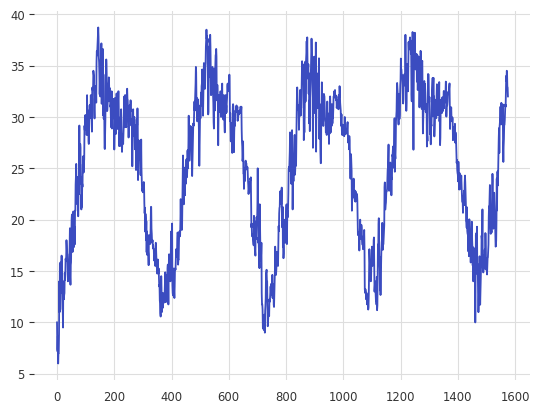

In [13]:
df.meantemp.plot(colormap='coolwarm')

viridis

plasma

inferno

magma

cividis

coolwarm

### make model just with meantemp

In [16]:
# ساخت سری زمانی
df_clean_ts_daily = fill_missing_values(
    TimeSeries.from_dataframe(
    df=df,
    time_col='date',
    value_cols=['meantemp'],
    fill_missing_dates=True,
    freq='D'
    ),fill = 'auto')

In [17]:
df_ts_daily = df_clean_ts_daily.astype(np.float32)

In [18]:
df_ts_daily

<TimeSeries (date: 1575, component: 1, sample: 1)> Size: 6kB
array([[[10.       ]],

       [[ 7.4      ]],

       [[ 7.1666665]],

       ...,

       [[32.9      ]],

       [[32.875    ]],

       [[32.       ]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 13kB 2013-01-01 2013-01-02 ... 2017-04-24
  * component  (component) object 8B 'meantemp'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [19]:
scaler_ts = Scaler()

In [20]:
df_ts_daily_transform = scaler_ts.fit_transform(df_ts_daily)

In [21]:
df_ts_daily_transform

<TimeSeries (date: 1575, component: 1, sample: 1)> Size: 6kB
array([[[0.12227073]],

       [[0.04279476]],

       [[0.03566229]],

       ...,

       [[0.82227075]],

       [[0.8215065 ]],

       [[0.7947598 ]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 13kB 2013-01-01 2013-01-02 ... 2017-04-24
  * component  (component) object 8B 'meantemp'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

<Axes: xlabel='date'>

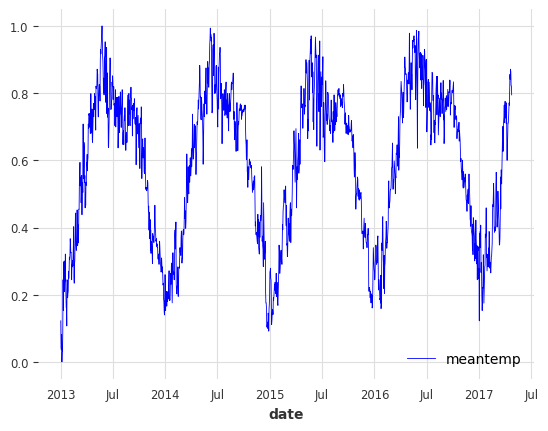

In [22]:
df_ts_daily_transform.plot(color='b',linewidth =0.6)

In [23]:
train_ts, val_test_ts = df_ts_daily_transform.split_after(0.7)
val_ts, test_ts = val_test_ts.split_after(0.5)

## past covariation

In [25]:
df_p = df.copy()

# محاسبه میانگین متحرک 7 روزه دما
df_p['ma_7'] = df['meantemp'].rolling(window=7).mean().bfill()

# انحراف معیار متحرک 7 روزه
df_p['std_7'] = df['meantemp'].rolling(window=7).std().bfill()

# نرخ تغییر نسبت به روز قبل
df_p['roc_1'] = df['meantemp'].pct_change(periods=1).bfill()



In [26]:
df_p.isin([np.inf, -np.inf]).sum()  # بررسی inf

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
ma_7            0
std_7           0
roc_1           0
dtype: int64

In [27]:
# df_p.replace([np.inf, -np.inf], np.nan, inplace=True)
# df_p = df_p.bfill().ffill()

In [28]:
print(df_p[["humidity","wind_speed","meanpressure", "ma_7", "std_7", "roc_1"]].iloc[0:10])

    humidity  wind_speed  meanpressure      ma_7     std_7     roc_1
0  84.500000    0.000000   1015.666667  7.604762  1.316903 -0.260000
1  92.000000    2.980000   1017.800000  7.604762  1.316903 -0.260000
2  87.000000    4.633333   1018.666667  7.604762  1.316903 -0.031532
3  71.333333    1.233333   1017.166667  7.604762  1.316903  0.209302
4  86.833333    3.700000   1016.500000  7.604762  1.316903 -0.307692
5  82.800000    1.480000   1018.000000  7.604762  1.316903  0.166667
6  78.600000    6.300000   1020.000000  7.604762  1.316903  0.000000
7  63.714286    7.142857   1018.714286  7.441497  1.004166  0.265306
8  51.250000   12.500000   1017.000000  8.384354  2.672062  0.580645
9  62.000000    7.400000   1015.666667  8.931973  2.771856 -0.214286


In [29]:
df_p.describe()

,meantemp,humidity,wind_speed,meanpressure,ma_7,std_7,roc_1
count,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000
mean,25.219873,60.417729,6.896178,1013.165186,25.170360,1.479377,0.003638
std,7.349107,16.971483,4.512019,168.914985,7.227078,0.692877,0.079834
min,6.000000,13.428571,0.000000,938.066667,7.441497,0.118387,-0.335664
25%,18.500000,49.750000,3.700000,1001.875000,18.366071,0.983263,-0.035485
50%,27.166667,62.375000,6.342857,1009.125000,27.556122,1.376442,0.003788
75%,31.142857,72.125000,9.262500,1015.225000,31.155612,1.880513,0.041808
max,38.714286,100.000000,42.220000,7679.333333,37.607143,4.203807,0.850000


In [30]:
df_p.isna().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
ma_7            0
std_7           0
roc_1           0
dtype: int64

In [31]:
df_p

,date,meantemp,humidity,wind_speed,meanpressure,ma_7,std_7,roc_1
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,7.604762,1.316903,-0.260000
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,7.604762,1.316903,-0.260000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,7.604762,1.316903,-0.031532
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,7.604762,1.316903,0.209302
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,7.604762,1.316903,-0.307692
...,...,...,...,...,...,...,...,...
1571,2017-04-20,34.500000,27.500000,5.562500,998.625000,32.468254,1.587910,0.029851
1572,2017-04-21,34.250000,39.375000,6.962500,999.875000,33.003968,1.438773,-0.007246
1573,2017-04-22,32.900000,40.900000,8.890000,1001.600000,33.243651,1.214803,-0.039416
1574,2017-04-23,32.875000,27.500000,9.962500,1002.125000,33.511508,0.758746,-0.000760


In [32]:
past_cov = fill_missing_values(
    TimeSeries.from_dataframe(
    df_p,
    time_col="date",
    value_cols=["humidity","wind_speed","meanpressure", "ma_7", "std_7", "roc_1"],
    #fill_missing_dates=True,
    freq="d"),fill = 'auto')

In [33]:
past_cov = past_cov.astype(np.float32)

In [34]:
past_cov.to_dataframe().isna().sum()  # بررسی NaN

humidity        0
wind_speed      0
meanpressure    0
ma_7            0
std_7           0
roc_1           0
dtype: int64

In [35]:
past_cov.to_dataframe().isin([np.inf, -np.inf]).sum()  # بررسی inf

humidity        0
wind_speed      0
meanpressure    0
ma_7            0
std_7           0
roc_1           0
dtype: int64

In [36]:
past_cov

<TimeSeries (date: 1575, component: 6, sample: 1)> Size: 38kB
array([[[ 8.4500000e+01],
        [ 0.0000000e+00],
        [ 1.0156667e+03],
        [ 7.6047621e+00],
        [ 1.3169028e+00],
        [-2.5999999e-01]],

       [[ 9.2000000e+01],
        [ 2.9800000e+00],
        [ 1.0178000e+03],
        [ 7.6047621e+00],
        [ 1.3169028e+00],
        [-2.5999999e-01]],

       [[ 8.7000000e+01],
        [ 4.6333332e+00],
        [ 1.0186667e+03],
        [ 7.6047621e+00],
        [ 1.3169028e+00],
        [-3.1531531e-02]],
...
       [[ 4.0900002e+01],
        [ 8.8900003e+00],
        [ 1.0016000e+03],
        [ 3.3243652e+01],
        [ 1.2148025e+00],
        [-3.9416060e-02]],

       [[ 2.7500000e+01],
        [ 9.9624996e+00],
        [ 1.0021250e+03],
        [ 3.3511509e+01],
        [ 7.5874603e-01],
        [-7.5987843e-04]],

       [[ 2.7142857e+01],
        [ 1.2157143e+01],
        [ 1.0041429e+03],
        [ 3.3432144e+01],
        [ 8.9264524e-01],
        [-2.6615970e-02]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 13kB 2013-01-01 2013-01-02 ... 2017-04-24
  * component  (component) object 48B 'humidity' 'wind_speed' ... 'roc_1'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [ ]:
scaler_cov = Scaler()
# این کار اشتباهیه البته زیرا فقط روی ترین باید فیت بشه و بقیه فقط ترنسفورم بشن
past_cov_scaled = scaler_cov.fit_transform(past_cov)

In [38]:
train_cov_pc, val_test_cov_pc = past_cov_scaled.split_after(0.7)
val_cov_pc, test_cov_pc = val_test_cov_pc.split_after(0.5)

## future covariation

In [40]:
# ایجاد هر ویژگی به‌صورت جداگانه
feat_day = datetime_attribute_timeseries(df_ts_daily_transform, attribute="day", one_hot=True,dtype=np.float32)
feat_month = datetime_attribute_timeseries(df_ts_daily_transform, attribute="month", one_hot=True,dtype=np.float32)
feat_weekday = datetime_attribute_timeseries(df_ts_daily_transform, attribute="weekday", one_hot=True,dtype=np.float32)

# ترکیب ویژگی‌ها
time_feat = concatenate([feat_day, feat_month, feat_weekday], axis=1)

In [41]:
scaler_ts = Scaler()
time_feat_transform = scaler_ts.fit_transform(time_feat)
train_cov_tf , val_cov_test_tf = time_feat_transform.split_after(0.7)
val_cov_tf, test_cov_tf = val_cov_test_tf.split_after(0.5)

In [42]:
logger = CSVLogger("lightning_logs", name="deepar_logs")

In [43]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",       # پایش بر اساس val_loss برای جلوگیری از overfitting
        patience=15,              # اگر بهبود نداشت تا ۱۰ epoch، متوقف شود
        min_delta=0.1,
        mode="min"
    ),
    ModelCheckpoint(
        monitor="val_loss",       # ذخیره بهترین مدل بر اساس val_loss
        save_top_k=1,
        mode="min",
        filename="best-rnn-model",
        verbose=True
    ),
    LearningRateMonitor(logging_interval='epoch'),  # پایش و لاگ نرخ یادگیری
    Timer(),                                         # زمان‌سنج برای آموزش
    RichProgressBar()                               # نوار پیشرفت زیبا
]


In [44]:
model_deepar = RNNModel(
    model="LSTM",
    input_chunk_length=30,
    training_length=60,
    hidden_dim=64,
    n_rnn_layers=2,
    dropout=0.2,
    batch_size=32,
    n_epochs=200, 
    likelihood=GaussianLikelihood(),
    random_state=42,
    model_name="rnn_deepar",
    force_reset=True,
    save_checkpoints=False,
    optimizer_kwargs={"lr": 5e-3},
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs={
        "mode": "min",
        "factor": 0.5,
        "patience": 5
    },
    pl_trainer_kwargs={
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "enable_checkpointing": True,
        "enable_progress_bar": True,
        "callbacks": callbacks,
        "logger": True
    }
)

In [45]:
torch.set_float32_matmul_precision('high')

In [ ]:
train_ts = train_ts.astype(np.float32)
val_ts = val_ts.astype(np.float32)
train_cov_pc = train_cov_pc.astype(np.float32)
val_cov_pc = val_cov_pc.astype(np.float32)


In [46]:
fited_model_deepar =model_deepar.fit(
                                    series=train_ts,
                                    # past_covariates=train_cov_pc,            # اگر past covariates داری
                                    future_covariates=train_cov_tf,           # ویژگی‌های زمانی آینده (temporal covariates)
                                    val_series=val_ts,
                                    # val_past_covariates=val_cov_pc,          # اگر past covariates داری
                                    val_future_covariates=val_cov_tf          # ویژگی‌های زمانی آینده برای اعتبارسنجی
                                )


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ criterion       │ MSELoss          │      0 │ train │
│ 1 │ train_criterion │ MSELoss          │      0 │ train │
│ 2 │ val_criterion   │ MSELoss          │      0 │ train │
│ 3 │ train_metrics   │ MetricCollection │      0 │ train │
│ 4 │ val_metrics     │ MetricCollection │      0 │ train │
│ 5 │ rnn             │ LSTM             │ 63.2 K │ train │
│ 6 │ V               │ Linear           │    130 │ train │
└───┴─────────────────┴──────────────────┴────────┴───────┘

Trainable params: 63.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 63.4 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 7                                                                                           
Modules in eval mode: 0

Output()

C:\ProgramData\anaconda3\envs\ai\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training 
batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for 
log_every_n_steps if you want to see logs for the training epoch.

Epoch 0, global step 33: 'val_loss' reached -0.31280 (best -0.31280), saving model to 'C:\\Users\\AERO\\Downloads\\Video\\my project\\climate-N-BEATS-deep ar\\lightning_logs\\version_3\\checkpoints\\best-rnn-model.ckpt' as top 1
Epoch 1, global step 66: 'val_loss' reached -0.53497 (best -0.53497), saving model to 'C:\\Users\\AERO\\Downloads\\Video\\my project\\climate-N-BEATS-deep ar\\lightning_logs\\version_3\\checkpoints\\best-rnn-model.ckpt' as top 1
Epoch 2, global step 99: 'val_loss' reached -0.57792 (best -0.57792), saving model to 'C:\\Users\\AERO\\Downloads\\Video\\my project\\climate-N-BEATS-deep ar\\lightning_logs\\version_3\\checkpoints\\best-rnn-model.ckpt' as top 1
Epoch 3, global step 132: 'val_loss' reached -0.61901 (best -0.61901), saving model to 'C:\\Users\\AERO\\Downloads\\Video\\my project\\climate-N-BEATS-deep ar\\lightning_logs\\version_3\\checkpoints\\best-rnn-model.ckpt' as top 1
Epoch 4, global step 165: 'val_loss' reached -0.84077 (best -0.84077), saving model

In [47]:
model_deepar.save("rnn_deepar_full")

In [48]:
model_deepar_loaded = RNNModel.load("rnn_deepar_full")

In [49]:
# ⚙️ گرفتن مقادیر لازم از مدل و تست‌ست
input_chunk_length = model_deepar_loaded.input_chunk_length
forecast_horizon = len(test_ts)

# 🧠 ساخت بازه زمانی لازم برای future_covariates
start_cov = test_ts.start_time() - pd.Timedelta(days=input_chunk_length)
end_cov = test_ts.end_time() + pd.Timedelta(days=forecast_horizon)

# 📅 تولید تقویم کامل از تاریخ شروع تا پایان پیش‌بینی
full_cov_dates = pd.date_range(start=start_cov, end=end_cov, freq="D")

# 🔁 تولید چند ویژگی زمانی جداگانه
feat_day = datetime_attribute_timeseries(full_cov_dates, attribute="day", one_hot=True, dtype=np.float32)
feat_month = datetime_attribute_timeseries(full_cov_dates, attribute="month", one_hot=True, dtype=np.float32)
feat_weekday = datetime_attribute_timeseries(full_cov_dates, attribute="weekday", one_hot=True, dtype=np.float32)

# 🔗 ترکیب همه ویژگی‌ها در یک TimeSeries
future_feat_full = concatenate([feat_day, feat_month, feat_weekday], axis=1)

# ⚖️ مقیاس‌گذاری با Scaler قبلاً fit شده روی train
test_cov_future = scaler_ts.transform(future_feat_full)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

✅ Test MAE: 0.08546654024492886
✅ Test MAPE: 18.081372796821952


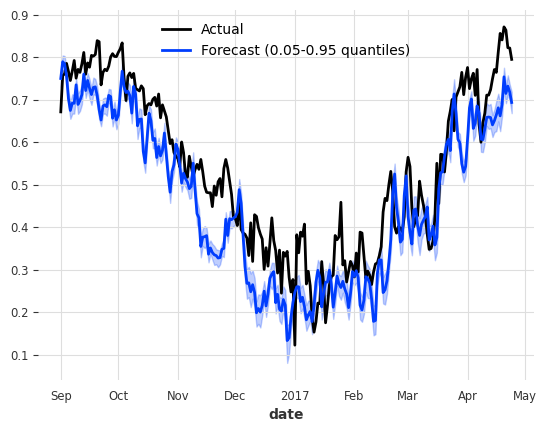

In [50]:
# پیش‌بینی روی test_ts
pred_test = model_deepar_loaded.predict(
    n=len(test_ts),
    series=train_ts.append(val_ts),
    future_covariates=test_cov_future,
    num_samples=100
)

# ارزیابی فقط روی بخش همپوشان
actual = test_ts.slice_intersect(pred_test)
forecast = pred_test.slice_intersect(test_ts)

if len(actual) > 0 and len(forecast) > 0:
    print("✅ Test MAE:", mae(actual, forecast))
    print("✅ Test MAPE:", mape(actual, forecast))

    actual.plot(label='Actual')
    forecast.plot(label='Forecast (0.05-0.95 quantiles)')
else:
    print("❌ No valid overlapping data between test set and prediction.")

In [51]:
print(f"تعداد پیش‌بینی‌ها: {len(pred_test)}")

تعداد پیش‌بینی‌ها: 236


In [52]:
# فرض کنید val_ts و val_cov_tf داده‌های اعتبارسنجی هستند
fit_kwargs = {
    "val_series": val_ts,
    "val_future_covariates": val_cov_tf,
    # اگر past_covariates دارید:
    # "val_past_covariates": val_cov_pc,
}

historical_forecasts_goog = model_deepar_loaded.historical_forecasts(
    series=df_ts_daily_transform,
    future_covariates=time_feat,
    num_samples=40,
    start=0.8,
    forecast_horizon=14,
    retrain=False,
    stride=30,
    last_points_only=False,
    fit_kwargs=fit_kwargs  # این خط را اضافه کنید
)


`fit_kwargs` was provided with `retrain=False`, the argument will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

In [53]:
import pickle

with open("historical_forecasts_goog.pkl", "wb") as f:
    pickle.dump(historical_forecasts_goog, f)


In [54]:
import pickle

# بارگذاری فایل
with open("historical_forecasts_goog.pkl", "rb") as f:
    historical_forecasts_goog = pickle.load(f)


In [55]:
error_score = model_deepar_loaded.backtest(
    series=df_ts_daily_transform,
    future_covariates=time_feat,
    historical_forecasts=historical_forecasts_goog,
    metric=[mae, mape, smape, rmse],
    retrain=False,
    verbose=True,
    last_points_only=False
)


In [56]:
print(f"MAE: {error_score[0]} , MAPA: {error_score[1]} , smape: {error_score[2]} , rmse: {error_score[3]}" )

MAE: 0.08515498932305868 , MAPA: 16.39329000753949 , smape: 17.89396159762079 , rmse: 0.0974059444316559


In [57]:

# ساخت Logger
logger_nbeats = CSVLogger("lightning_logs", name="nbeats_logs")

# تعریف callbacks دقیقاً مشابه قبلی
callbacks_nbeats = [
    EarlyStopping(
        monitor="val_loss",
        patience=15,
        min_delta=0.1,
        mode="min"
    ),
    ModelCheckpoint(
        monitor="val_loss",
        save_top_k=1,
        mode="min",
        filename="best-nbeats-model",
        verbose=True
    ),
    LearningRateMonitor(logging_interval='epoch'),
    Timer(),
    # RichProgressBar()
]

# تعریف مدل N-BEATS با ساختار مشابه RNNModel شما
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    n_epochs=200,
    batch_size=32,
    random_state=42,
    model_name="nbeats_model",
    force_reset=True,
    save_checkpoints=False,
    # likelihood=GaussianLikelihood(),  # اگر بخواهید شبیه DeepAR شود
    optimizer_kwargs={"lr": 5e-3},
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs={
        "mode": "min",
        "factor": 0.5,
        "patience": 5
    },
    pl_trainer_kwargs={
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "enable_checkpointing": True,
        "enable_progress_bar": True,
        "callbacks": callbacks_nbeats,
        "logger": logger_nbeats
    }
)

In [58]:
fited_model_nbeats = model_nbeats.fit(
                                    series=train_ts,
                                    past_covariates=train_cov_pc,
                                    val_series=val_ts,
                                    val_past_covariates=val_cov_pc
                                )

model_nbeats.save("nbeats_model_full")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 7.7 M  | train
-------------------------------------------------------------
7.7 M     Trainable params
2.5 K     Non-trainable params
7.7 M     Total params
30.677    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\ProgramData\anaconda3\envs\ai\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 34: 'val_loss' reached 0.02955 (best 0.02955), saving model to 'lightning_logs\\nbeats_logs\\version_2\\checkpoints\\best-nbeats-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 68: 'val_loss' reached 0.00756 (best 0.00756), saving model to 'lightning_logs\\nbeats_logs\\version_2\\checkpoints\\best-nbeats-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 102: 'val_loss' reached 0.00530 (best 0.00530), saving model to 'lightning_logs\\nbeats_logs\\version_2\\checkpoints\\best-nbeats-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 136: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 170: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 204: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 238: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 272: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 306: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 340: 'val_loss' reached 0.00471 (best 0.00471), saving model to 'lightning_logs\\nbeats_logs\\version_2\\checkpoints\\best-nbeats-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 374: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 408: 'val_loss' reached 0.00433 (best 0.00433), saving model to 'lightning_logs\\nbeats_logs\\version_2\\checkpoints\\best-nbeats-model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 442: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 476: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 510: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 544: 'val_loss' was not in top 1


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

✅ Test MAE: 0.05738843
✅ Test MAPE: 13.646559


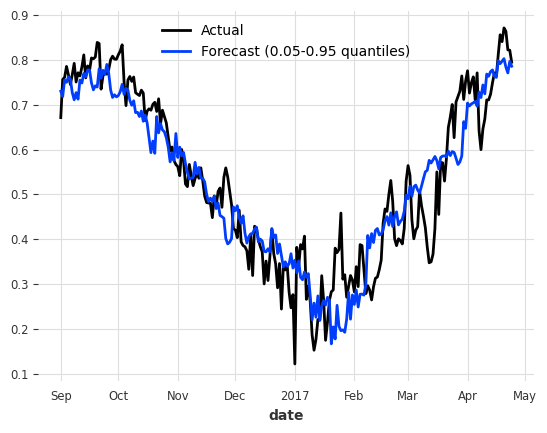

In [61]:
# پیش‌بینی روی test_ts
pred_test = fited_model_nbeats.predict(
    n=len(test_ts),
    series=train_ts.append(val_ts),
    #future_covariates=test_cov_future,
    past_covariates = past_cov_scaled,
    #num_samples=100
)

# ارزیابی فقط روی بخش همپوشان
actual = test_ts.slice_intersect(pred_test)
forecast = pred_test.slice_intersect(test_ts)

if len(actual) > 0 and len(forecast) > 0:
    print("✅ Test MAE:", mae(actual, forecast))
    print("✅ Test MAPE:", mape(actual, forecast))

    actual.plot(label='Actual')
    forecast.plot(label='Forecast (0.05-0.95 quantiles)')
else:
    print("❌ No valid overlapping data between test set and prediction.")